In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir('..')

In [3]:
import pickle
import itertools
import glob
import json
from PIL import Image

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import configs
from utils import laion_utils as laionu
from utils.ilsvrc_utils import load_lemmas_and_wnids
from core.queries import QueryType

[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Settings

## Path

In [15]:
# LAION
laion_path = 'laion400m'
laion_until_part = 31

laionet_prefix = 'subset_sm_filt(text_to_name_def_wnid_similarity_all-mpnet-base-v2)'

sm_file_name = laionet_prefix + '_' + laionu.get_laion_subset_file_name(0, laion_until_part)

ic_ms_file_name = configs.LAIONConfig.SUBSET_IC_MOST_SIMILAR_TXT_TXT_PREFIX \
                + laionu.get_laion_subset_file_name(0, laion_until_part)

# ILSVRC
ilsvrc_path = 'ilsvrc2012'

ival_file_name = 'ILSVRC2012_val.parquet'

# IC
ic_path = 'imagenet-captions'
ic_file_name = 'imagenet_captions.parquet'

# Labels (maps)
laion_labels_path = os.path.join('laion400m', 'processed', 'ilsvrc_labels')

sm_wnid2laionindices_file_name = 'wnid2laionindices(substring_matched).pkl'

ilsvrc_labels_path = os.path.join(ilsvrc_path, 'processed', 'labels')
ic_labels_path = os.path.join(ic_path, 'processed', 'labels')

ic_imagename2wnid_file_name = 'icimagename2wnid.pkl'
ival_imagename2wnid_file_name = 'imagename2wnid.pkl'

## Column names

In [16]:
chosen_q_type = QueryType.NAME_DEF

# Image-query similarity
image_query_sim_col = f'image_to_{chosen_q_type}_wnid_similarity'

# Text-query similarity
text_query_sim_col = f'text_to_{chosen_q_type}_wnid_similarity'

# Loading

## Load SM LAION subset

In [18]:
sm_df = pd.read_parquet(
    os.path.join(laion_path, sm_file_name)
)

print(sm_df.shape)

sm_df.head(3)

(1297309, 74)


,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,name_def_wnid,text_to_name_def_wnid_similarity_clip-vit-base-patch32,...,top_5_is_correct_convnext-large-384,top_1_is_correct_convnext-base-224-22k-1k,top_5_is_correct_convnext-base-224-22k-1k,top_1_is_correct_convnext-large-224-22k-1k,top_5_is_correct_convnext-large-224-22k-1k,top_1_is_correct_convnext-base-384-22k-1k,top_5_is_correct_convnext-base-384-22k-1k,top_1_is_correct_convnext-large-384-22k-1k,top_5_is_correct_convnext-large-384-22k-1k,wnid_is_in_recognized_text
433,1.939175e+12,https://media.istockphoto.com/photos/grasshopp...,grasshopper isolated - Tettigonia viridissima ...,1024.0,682.0,?,UNLIKELY,0.343179,grasshopper which is terrestrial plant-eating ...,0.805295,...,True,True,True,True,True,True,True,True,True,False
780,2.457600e+10,http://img3.etsystatic.com/000/1/5677244/il_17...,Doily //tiny// sterling silver & pewter necklace,170.0,135.0,?,UNLIKELY,0.316737,necklace which is jewelry consisting of a cord...,0.614638,...,True,False,True,False,True,False,True,False,True,False
2062,1.133807e+10,https://t2.ftcdn.net/jpg/00/14/35/49/110_F_143...,close-up on a feline' eye - Eurasian Lynx - Ly...,110.0,110.0,?,UNLIKELY,0.326179,lynx which is short-tailed wildcats with usual...,0.723028,...,True,False,True,False,True,False,True,True,True,False


In [19]:
sm_df = sm_df[sm_df['wnid_is_in_recognized_text'] == False]

## Load IC most similar subset

In [20]:
ic_ms_df = pd.read_parquet(
    os.path.join(laion_path, ic_ms_file_name)
)

print(ic_ms_df.shape)

ic_ms_df.head(3)

(161903, 11)


,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,image_to_text_similarity,name_def_wnid,text_to_name_def_wnid_similarity
1271,1.883650e+11,https://thumbs.dreamstime.com/t/calton-cemeter...,Calton cemetery and obelisk Edinburgh Stock Ph...,241.0,160.0,?,UNLIKELY,0.322448,0.310787,obelisk which is a stone pillar having a recta...,0.665240
2891,3.478983e+12,https://ssl.c.photoshelter.com/img-get2/I0000P...,LHS basketball Laconia versus Kennett at Lacon...,200.0,135.0,?,UNLIKELY,0.309529,0.318361,basketball which is an inflated ball used in p...,0.379896
2901,9.773084e+09,http://cache-graphicslib.viator.com/graphicsli...,Photo of Sydney Sydney Harbour Highlights Crui...,260.0,195.0,?,UNLIKELY,0.334991,0.334656,None,NaN


## Load ILSVRC val set

In [21]:
ival_df = pd.read_parquet(os.path.join(ilsvrc_path, ival_file_name))

print(ival_df.shape)

ival_df.tail(3)

(50000, 61)


,name_def_wnid,top_1_is_correct_clip-vit-base-patch32,top_5_is_correct_clip-vit-base-patch32,top_1_is_correct_resnet-18,top_5_is_correct_resnet-18,top_1_is_correct_resnet-34,top_5_is_correct_resnet-34,top_1_is_correct_resnet-50,top_5_is_correct_resnet-50,top_1_is_correct_resnet-101,...,top_1_is_correct_convnext-large-384,top_5_is_correct_convnext-large-384,top_1_is_correct_convnext-base-224-22k-1k,top_5_is_correct_convnext-base-224-22k-1k,top_1_is_correct_convnext-large-224-22k-1k,top_5_is_correct_convnext-large-224-22k-1k,top_1_is_correct_convnext-base-384-22k-1k,top_5_is_correct_convnext-base-384-22k-1k,top_1_is_correct_convnext-large-384-22k-1k,top_5_is_correct_convnext-large-384-22k-1k
ILSVRC2012_val_00049998.JPEG,border collie which is developed in the area b...,True,True,True,True,True,True,False,True,True,...,False,True,True,True,True,True,True,True,True,True
ILSVRC2012_val_00049999.JPEG,groom which is a man participant in his own ma...,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
ILSVRC2012_val_00050000.JPEG,llama which is wild or domesticated South Amer...,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


## Load ImageNet-Captions

In [22]:
ic_df = pd.read_parquet(os.path.join('imagenet-captions', ic_file_name))

print(ic_df.shape)

ic_df.tail(3)

(443798, 5)


,TEXT,image_to_name_def_wnid_similarity,name_def_wnid,image_to_text_similarity,text_to_name_def_wnid_similarity
ic_index,,,,,
n15075141_9819.JPEG,Margaret Thatcher toilet paper Margaret Thatch...,0.255074,toilet tissue which is a soft thin absorbent p...,0.321070,0.672603
n15075141_9942.JPEG,Toilet Roll II toilet roll II toilet roll duan...,0.322143,toilet tissue which is a soft thin absorbent p...,0.284109,0.721321
n15075141_9993.JPEG,Toilet Paper toilet paper flush light green wa...,0.271322,toilet tissue which is a soft thin absorbent p...,0.294822,0.380635


## Load maps

In [23]:
with open(os.path.join(laion_labels_path, sm_wnid2laionindices_file_name), 'rb') as f:
    sm_wnid2laionindices = pickle.load(f)
    
# Drop empty indices
sm_wnid2laionindices = {wnid: indices for wnid, indices in sm_wnid2laionindices.items() if len(indices) > 0}

# Find the inverse map
sm_laionindex2wnids = {}

for wnid, laion_indices in tqdm(sm_wnid2laionindices.items()):
    for laion_idx in laion_indices:
        if laion_idx not in sm_df.index:
            continue
            
        if laion_idx not in sm_laionindex2wnids:
            sm_laionindex2wnids[laion_idx] = []
        sm_laionindex2wnids[laion_idx].append(wnid)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:03<00:00, 305.59it/s]


In [24]:
with open(os.path.join(ilsvrc_labels_path, ival_imagename2wnid_file_name), 'rb') as f:
    ival_imagename2wnid = pickle.load(f)
    
# Find the inverse map
ival_wnid2imagenames = {}
for image_name, wnid in ival_imagename2wnid.items():    
    if wnid not in ival_wnid2imagenames:
        ival_wnid2imagenames[wnid] = []
    ival_wnid2imagenames[wnid].append(image_name)

In [25]:
with open(os.path.join(ic_labels_path, ic_imagename2wnid_file_name), 'rb') as f:
    ic_imagename2wnid = pickle.load(f)
    
# Find the inverse map
ic_wnid2imagenames = {}
for image_name, wnid in ic_imagename2wnid.items():    
    if wnid not in ic_wnid2imagenames:
        ic_wnid2imagenames[wnid] = []
    ic_wnid2imagenames[wnid].append(image_name)

# Compare distribution of image-query sim.

## Resample

In [26]:
all_resampled_sm_laion_indices = []
all_resampled_ival_image_names = []

for wnid, laion_indices in sm_wnid2laionindices.items():
    if wnid not in ival_wnid2imagenames:
        continue
        
    resampled_ival_image_names = np.array(ival_wnid2imagenames[wnid])
    
    resampled_sm_laion_indices = np.random.choice(
        laion_indices, 
        size=(len(resampled_ival_image_names),), 
        replace=True
    )
    
    all_resampled_sm_laion_indices.extend(resampled_sm_laion_indices)
    all_resampled_ival_image_names.extend(resampled_ival_image_names)
    
print(len(all_resampled_sm_laion_indices), len(all_resampled_ival_image_names))

45900 45900


In [27]:
sm_iqsims = sm_df.loc[all_resampled_sm_laion_indices, image_query_sim_col].tolist()
ival_iqsims = ival_df.loc[all_resampled_ival_image_names, image_query_sim_col].tolist()

KeyError: 'image_to_name_def_wnid_similarity'

## Plot distributions

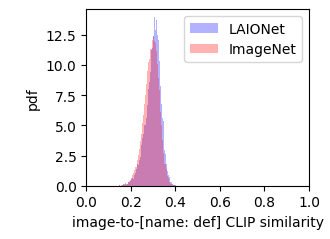

In [13]:
plt.figure(figsize=(3.4, 2.5))

plt.hist(sm_iqsims, bins=60, color='b', alpha=0.3, density=True)
plt.hist(ival_iqsims, bins=60, color='r', alpha=0.3, density=True)

plt.xlabel('image-to-[name: def] CLIP similarity')
plt.ylabel('\npdf')

plt.legend(['LAIONet', 'ImageNet'])

plt.xlim([0, 1])

plt.tight_layout()

plt.savefig(os.path.join('figs', 'distribution_image-query_sim.pdf'), bbox_inches='tight')

## Test per WNID

In [14]:
sm_avg_iqsims = []
sm_err_iqsims = []
ival_avg_iqsims = []
ival_err_iqsims = []

for wnid, laion_indices in tqdm(sm_wnid2laionindices.items()):
    if wnid not in ival_wnid2imagenames:
        continue
        
    sm_iqsims = np.array(sm_df.loc[laion_indices, image_query_sim_col].tolist())
    sm_iqsims = sm_iqsims[~np.isnan(sm_iqsims)]
    
    ival_iqsims = np.array(ival_df.loc[ival_wnid2imagenames[wnid], image_query_sim_col].tolist())
    ival_iqsims = ival_iqsims[~np.isnan(ival_iqsims)]
    
    if len(sm_iqsims) < 7 or len(ival_iqsims) < 7:
        continue
        
    sm_avg_iqsims.append(np.mean(sm_iqsims))
    sm_err_iqsims.append(1.96*np.std(sm_iqsims)/np.sqrt(len(sm_iqsims) - 1))
    
    ival_avg_iqsims.append(np.mean(ival_iqsims))
    ival_err_iqsims.append(1.96*np.std(ival_iqsims)/np.sqrt(len(ival_iqsims) - 1))
    
sm_avg_iqsims = np.array(sm_avg_iqsims)
sm_err_iqsims = np.array(sm_err_iqsims)
ival_avg_iqsims = np.array(ival_avg_iqsims)
ival_err_iqsims = np.array(ival_err_iqsims)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 918/918 [00:00<00:00, 929.18it/s]


avg > 0: 0.682983682983683
UCB < 0: 118 out of 858 (0.13752913752913754)
LCB > 0: 373 out of 858 (0.4347319347319347)


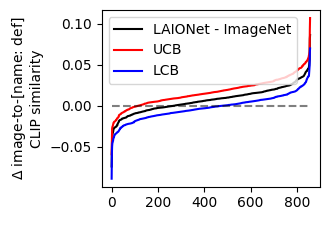

In [15]:
plt.figure(figsize=(3.4, 2.5))

diff_avg_iqsims = sm_avg_iqsims - ival_avg_iqsims
diff_err_iqsims = np.sqrt(sm_err_iqsims**2 + ival_err_iqsims**2)

sorted_locs = np.argsort(diff_avg_iqsims)

ucb_iqsims = np.sort(diff_avg_iqsims + diff_err_iqsims)
lcb_iqsims = np.sort(diff_avg_iqsims - diff_err_iqsims)

x = range(len(sorted_locs))

plt.plot(x, diff_avg_iqsims[sorted_locs], color='k')
plt.plot(x, ucb_iqsims, 'r')
plt.plot(x, lcb_iqsims, 'b')

plt.plot(x, [0]*len(x), 'k--', alpha=0.5)

plt.legend(['LAIONet - ImageNet', 'UCB', 'LCB'])

plt.xlabel(' ')
plt.ylabel(r'$\Delta$ image-to-[name: def]' + '\n' + 'CLIP similarity')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'image-query_sim_diff.pdf'), bbox_inches='tight')

print(f'avg > 0: {np.mean(diff_avg_iqsims > 0)}')
print(f'UCB < 0: {np.sum(ucb_iqsims < 0)} out of {len(ucb_iqsims)} ({np.mean(ucb_iqsims < 0)})')
print(f'LCB > 0: {np.sum(lcb_iqsims > 0)} out of {len(lcb_iqsims)} ({np.mean(lcb_iqsims > 0)})')

# Compare distribution of text-query sim.

## Settings

In [28]:
ic_all_file_name = 'imagenet_captions_with_sims_to_all_queries.parquet'

synsets_file_name = 'ILSVRC2012_synsets.txt'

In [29]:
ic_text_to_query_col_func = lambda w: f'text_to_name_def_{w}_similarity'

sm_text_to_query_col = f'text_to_name_def_wnid_similarity_all-mpnet-base-v2'

## Load

In [30]:
ic_all_df = pd.read_parquet(os.path.join(ic_path, ic_all_file_name))

ic_all_df.tail(3)

,TEXT,image_to_name_def_wnid_similarity,name_def_wnid,image_to_text_similarity,text_to_name_def_wnid_similarity,text_to_name_def_n02119789_similarity,text_to_name_def_n02100735_similarity,text_to_name_def_n02096294_similarity,text_to_name_def_n02066245_similarity,text_to_name_def_n02509815_similarity,...,text_to_name_def_n02091032_similarity,text_to_name_def_n02102318_similarity,text_to_name_def_n02102480_similarity,text_to_name_def_n02113023_similarity,text_to_name_def_n02086646_similarity,text_to_name_def_n02091244_similarity,text_to_name_def_n02089973_similarity,text_to_name_def_n02105251_similarity,text_to_name_def_n02093754_similarity,text_to_name_def_n02112837_similarity
ic_index,,,,,,,,,,,,,,,,,,,,,
n15075141_9819.JPEG,Margaret Thatcher toilet paper Margaret Thatch...,0.255074,toilet tissue which is a soft thin absorbent p...,0.321070,0.672603,0.314751,0.302764,0.376714,0.353923,0.375146,...,0.385962,0.425324,0.274066,0.418079,0.320774,0.332809,0.360865,0.330163,0.374264,0.359121
n15075141_9942.JPEG,Toilet Roll II toilet roll II toilet roll duan...,0.322143,toilet tissue which is a soft thin absorbent p...,0.284109,0.721321,0.392613,0.283349,0.407590,0.410512,0.376387,...,0.434423,0.416335,0.250755,0.428895,0.288285,0.323935,0.369291,0.318132,0.382490,0.441221
n15075141_9993.JPEG,Toilet Paper toilet paper flush light green wa...,0.271322,toilet tissue which is a soft thin absorbent p...,0.294822,0.380635,0.107943,0.129566,0.120912,0.165459,0.166710,...,0.156739,0.161972,0.089361,0.150558,0.098518,0.148388,0.154622,0.099526,0.142871,0.176329


In [31]:
id_lemmas_df = load_lemmas_and_wnids(os.path.join(ilsvrc_path, 'ILSVRC2012_synsets.txt'))
all_wnids = id_lemmas_df[configs.ILSVRCConfigs.WNID_COL].tolist()

## Plot distribution

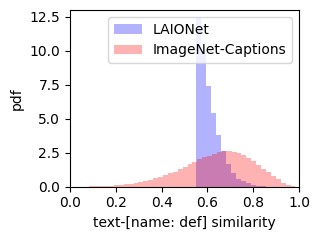

In [32]:
plt.figure(figsize=(3.3, 2.5))

_ = plt.hist(sm_df[sm_text_to_query_col].tolist(), bins=20, color='b', alpha=0.3, density=True)
ibins = plt.hist(ic_df[text_query_sim_col].tolist(), bins=50, color='r', alpha=0.3, density=True)

plt.legend(['LAIONet', 'ImageNet-Captions'])

plt.xlabel('text-[name: def] similarity')
plt.ylabel('pdf')

plt.xlim([0, 1])

plt.tight_layout()

plt.savefig(os.path.join('figs', f'text-query_sim_distribution_{laionet_prefix}.pdf'), bbox_inches='tight')

## Extract text to queries sim. matrix

In [21]:
sim_mat = ic_all_df.loc[
    [image_name for image_name in ic_imagename2wnid], 
    [text_to_query_col_func(wnid) for wnid in all_wnids]
].to_numpy()

print(sim_mat.shape)

(443798, 999)


## Calc. proportion of more similar false classes

In [22]:
p_vals = np.zeros((len(ic_imagename2wnid),))

for i_i, image_name in enumerate(tqdm(ic_imagename2wnid)):
    wnid = ic_imagename2wnid[image_name]
    
    if wnid not in all_wnids:
        continue
    
    p_vals[i_i] = np.mean(sim_mat[i_i, all_wnids.index(wnid)] < sim_mat[i_i])

100%|███████████████████████████████████████████████████████████████████████████████████████████| 443798/443798 [00:13<00:00, 31973.89it/s]


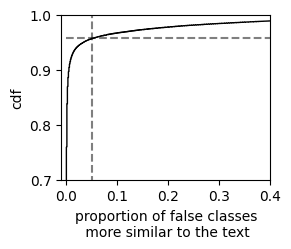

In [24]:
plt.figure(figsize=(3.1, 2.6))

_ = plt.hist(p_vals, bins=1000, cumulative=1, density=True, histtype='step', color='k')

plt.plot([0.05, 0.05], [0, 1], 'k--', alpha=0.5)
plt.plot([0, 1], [0.957, 0.957], 'k--', alpha=0.5)

plt.xlim([-1e-2, 0.4])
plt.ylim([0.7, 1])

plt.xlabel('proportion of false classes\n more similar to the text')
plt.ylabel('cdf')

plt.tight_layout()

# plt.savefig(os.path.join('figs', 'cdf_proportion_of_more_similar_false_classes.pdf'), bbox_inches='tight')

## Calc. proportion of more similar false classes per bin

In [25]:
image_names = [image_name for image_name in ic_imagename2wnid]

tq_sims = ic_all_df.loc[image_names, text_query_sim_col].to_numpy()

mean_bs = []
mean_ps = []
err_ps = []
for i_b, b_0 in enumerate(ibins[1][:-1]):
    b_1 = ibins[1][i_b + 1]
    
    mean_bs.append((b_0 + b_1)/2)
    
    p_vals_b = p_vals[np.logical_and(b_0 <= tq_sims,  tq_sims < b_1)]
    mean_ps.append(np.mean(p_vals_b))
    err_ps.append(1.96*np.sqrt(mean_ps[-1]*(1 - mean_ps[-1])/len(p_vals_b)))
    
mean_ps = np.array(mean_ps)
err_ps = np.array(err_ps)

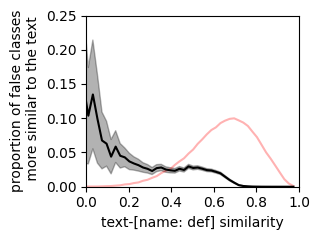

In [26]:
plt.figure(figsize=(3.3, 2.5))

plt.plot(mean_bs, ibins[0]/250000, 'r', alpha=0.3)

plt.plot(mean_bs, mean_ps, 'k')
plt.fill_between(mean_bs, mean_ps + err_ps, mean_ps - err_ps, color='k', alpha=0.3)

plt.xlabel('text-[name: def] similarity')
plt.ylabel('proportion of false classes\n more similar to the text')

plt.xlim([0, 1])
plt.ylim([0, 0.25])

plt.tight_layout()

plt.savefig(os.path.join('figs', 'text-query_sim_distribution_augmented.pdf'), bbox_inches='tight')

# Compare intra-class image similarities

## Settings

In [33]:
sm_prefix = laionet_prefix
ic_prefix = 'imagenet_captions'

cross_image_sim_prefix = '_img_img_sims'
cross_image_sim_path = os.path.join('laion400m', 'processed', 'clip_image_similarities')

In [34]:
def vec(x):
    msk = np.tril(np.eye(len(x)) < 0.5)
    return x[msk]

## Load similarities

In [35]:
wnid2smsims = {}
wnid2icsims = {}

for wnid in tqdm(all_wnids):
    sm_sim_path = os.path.join(cross_image_sim_path, sm_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    ic_sim_path = os.path.join(cross_image_sim_path, ic_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    
    if (not os.path.exists(sm_sim_path)) or (not os.path.exists(ic_sim_path)):
        continue

    with open(sm_sim_path, 'rb') as f:
        sm_sim_dict = pickle.load(f)
    with open(ic_sim_path, 'rb') as f:
        ic_sim_dict = pickle.load(f) 
        
    if not isinstance(sm_sim_dict, dict):
        continue
        
    sm_sim = sm_sim_dict['similarities']
    ic_sim = ic_sim_dict['similarities']
        
    # Extract sims.
    wnid2smsims[wnid] = vec(sm_sim)
    wnid2icsims[wnid] = vec(ic_sim)
    
print(len(wnid2smsims))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:04<00:00, 241.26it/s]

930


## Resample

In [36]:
rs_sm_sims = []
rs_ic_sims = []

for wnid, sm_sims in wnid2smsims.items():
    ic_sims = wnid2icsims[wnid]
    
    n_s_i = np.min([len(ic_sims), 100])
        
    rs_sm_sims.extend(np.random.choice(sm_sims, size=(n_s_i,), replace=True))
    rs_ic_sims.extend(np.random.choice(ic_sims, size=(n_s_i,), replace=True))

## Plot

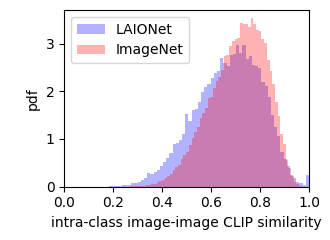

In [37]:
plt.figure(figsize=(3.4, 2.5))

_ = plt.hist(rs_sm_sims, bins=70, color='b', alpha=0.3, density=True)
_ = plt.hist(rs_ic_sims, bins=70, color='r', alpha=0.3, density=True)

plt.legend(['LAIONet', 'ImageNet'])

plt.xlabel('intra-class image-image CLIP similarity')
plt.ylabel('\npdf')

plt.xlim([0, 1])

plt.tight_layout()

plt.savefig(os.path.join('figs', f'{sm_prefix}{ic_prefix}{cross_image_sim_prefix}_resampled.pdf'), bbox_inches='tight')

## Test per WNID

In [38]:
sm_avg_intrasims = []
sm_err_intrasims = []
ic_avg_intrasims = []
ic_err_intrasims = []

for wnid, sm_intrasims in tqdm(wnid2smsims.items()):
    ic_intrasims = wnid2icsims[wnid]
    
    if len(sm_intrasims) < 7 or len(ic_intrasims) < 7:
        continue
        
    sm_avg_intrasims.append(np.mean(sm_intrasims))
    sm_err_intrasims.append(1.96*np.std(sm_intrasims)/np.sqrt(len(sm_intrasims) - 1))
    
    ic_avg_intrasims.append(np.mean(ic_intrasims))
    ic_err_intrasims.append(1.96*np.std(ic_intrasims)/np.sqrt(len(ic_intrasims) - 1))
    
sm_avg_intrasims = np.array(sm_avg_intrasims)
sm_err_intrasims = np.array(sm_err_intrasims)
ic_avg_intrasims = np.array(ic_avg_intrasims)
ic_err_intrasims = np.array(ic_err_intrasims)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 930/930 [00:00<00:00, 4006.36it/s]


avg < 0: 0.7598684210526315
UCB < 0: 644 out of 912 (0.706140350877193)
LCB > 0: 186 out of 912 (0.20394736842105263)


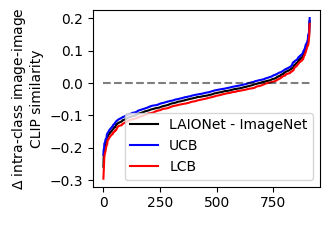

In [39]:
plt.figure(figsize=(3.4, 2.5))

diff_avg_intrasims = sm_avg_intrasims - ic_avg_intrasims
diff_err_intrasims = np.sqrt(sm_err_intrasims**2 + ic_err_intrasims**2)

sorted_locs = np.argsort(diff_avg_intrasims)

ucb_intrasims = np.sort(diff_avg_intrasims + diff_err_intrasims)
lcb_intrasims = np.sort(diff_avg_intrasims - diff_err_intrasims)

x = range(len(sorted_locs))

plt.plot(x, diff_avg_intrasims[sorted_locs], color='k')
plt.plot(x, ucb_intrasims, 'b')
plt.plot(x, lcb_intrasims, 'r')

plt.plot(x, [0]*len(x), 'k--', alpha=0.5)

plt.legend(['LAIONet - ImageNet', 'UCB', 'LCB'])

plt.xlabel(' ')
plt.ylabel(r'$\Delta$ intra-class image-image' + '\n' + 'CLIP similarity')

plt.tight_layout()

plt.savefig(os.path.join('figs', f'{sm_prefix}{ic_prefix}_intra-class_image-image_sim_diff.pdf'), bbox_inches='tight')

print(f'avg < 0: {np.mean(diff_avg_intrasims < 0)}')
print(f'UCB < 0: {np.sum(ucb_intrasims < 0)} out of {len(ucb_intrasims)} ({np.mean(ucb_intrasims < 0)})')
print(f'LCB > 0: {np.sum(lcb_intrasims > 0)} out of {len(lcb_intrasims)} ({np.mean(lcb_intrasims > 0)})')

# Compare intra-class cross image similarities for IC most similar texts

## Settings

In [34]:
tt_sim_th = 0.7

In [35]:
ic_ms_prefix = configs.LAIONConfig.SUBSET_IC_MOST_SIMILAR_TXT_TXT_PREFIX

ic_ms_imagename2laionindices_file_name = 'icimagename2laionindices.pkl'
ic_ms_imagename2sims_file_name = 'icimagename2sims.pkl'

## Load and preprocess

In [36]:
with open(os.path.join(laion_labels_path, ic_ms_imagename2laionindices_file_name), 'rb') as f:
    ic_ms_imagename2laionindices = pickle.load(f)
    
with open(os.path.join(laion_labels_path, ic_ms_imagename2sims_file_name), 'rb') as f:
    ic_ms_imagename2ictextsims = pickle.load(f)
    
ic_ms_wnid2laionindices = {}
ic_ms_wnid2ictextsims = {}

for image_name, wnid in ic_imagename2wnid.items():
    if wnid not in ic_ms_wnid2laionindices:
        ic_ms_wnid2laionindices[wnid] = []
        ic_ms_wnid2ictextsims[wnid] = []
        
    assert len(ic_ms_imagename2laionindices[image_name]) == 1
    assert len(ic_ms_imagename2ictextsims[image_name]) == 1
    
    ic_ms_wnid2laionindices[wnid].extend(ic_ms_imagename2laionindices[image_name])
    ic_ms_wnid2ictextsims[wnid].extend(ic_ms_imagename2ictextsims[image_name])

## Load and filter similarites

In [37]:
wnid2icmssims = {}
wnid2icsims = {}

for wnid in tqdm(all_wnids):
    ic_ms_sim_path = os.path.join(cross_image_sim_path, ic_ms_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    ic_sim_path = os.path.join(cross_image_sim_path, ic_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
        
    if (not os.path.exists(ic_ms_sim_path)) or (not os.path.exists(ic_sim_path)):
        continue

    with open(ic_ms_sim_path, 'rb') as f:
        ic_ms_sim_dict = pickle.load(f)
    with open(ic_sim_path, 'rb') as f:
        ic_sim_dict = pickle.load(f)
        
    ic_ms_sim = ic_ms_sim_dict['similarities']
    ic_sim = ic_sim_dict['similarities']
    
    # Choose tha samples
    tt_sims = np.array(ic_ms_wnid2ictextsims[wnid])
    laion_indices = np.array(ic_ms_wnid2laionindices[wnid])
    laion_indices = laion_indices[tt_sims > tt_sim_th]
    
    # Filter sims
    locs_filtered = [
        ic_ms_sim_dict['index'].index(laion_index) for laion_index in laion_indices
        if laion_index in ic_ms_sim_dict['index']
    ]
    
    ic_ms_sim = ic_ms_sim[locs_filtered][:, locs_filtered]
    
    if len(ic_ms_sim) <= 1:
        continue
        
    # Extract sims.
    wnid2icmssims[wnid] = vec(ic_ms_sim)
    wnid2icsims[wnid] = vec(ic_sim)
    
print(len(wnid2icmssims))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 362.97it/s]

962


## Resample

In [38]:
rs_ic_ms_sims = []
rs_ic_sims = []

for wnid, ic_ms_sims in wnid2icmssims.items():
    if wnid not in wnid2icsims: 
        continue 
        
    ic_sims = wnid2icsims[wnid]
    
    n_s_i = np.min([len(ic_sims), 100])
        
    rs_ic_ms_sims.extend(np.random.choice(ic_ms_sims, size=(n_s_i,), replace=True))
    rs_ic_sims.extend(np.random.choice(ic_sims, size=(n_s_i,), replace=True))

# Plot

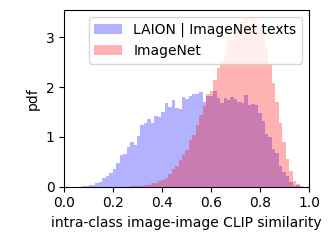

In [39]:
plt.figure(figsize=(3.4, 2.5))

_ = plt.hist(rs_ic_ms_sims, bins=70, color='b', alpha=0.3, density=True, range=(0, 0.99))
_ = plt.hist(rs_ic_sims, bins=70, color='r', alpha=0.3, density=True, range=(0, 0.99))

plt.legend(['LAION | ImageNet texts', 'ImageNet'])

plt.xlabel('intra-class image-image CLIP similarity')
plt.ylabel('\npdf')

plt.xlim([0, 1])

plt.tight_layout()

plt.savefig(os.path.join('figs', f'{ic_ms_prefix}{ic_prefix}{cross_image_sim_prefix}_resampled.pdf'), bbox_inches='tight')

# Test per WNID

In [40]:
ic_ms_avg_intrasims = []
ic_ms_err_intrasims = []
ic_avg_intrasims = []
ic_err_intrasims = []

for wnid, ic_ms_intrasims in tqdm(wnid2icmssims.items()):
    ic_intrasims = wnid2icsims[wnid]
    
    if len(ic_ms_intrasims) < 7 or len(ic_intrasims) < 7:
        continue
        
    ic_ms_avg_intrasims.append(np.mean(ic_ms_intrasims))
    ic_ms_err_intrasims.append(1.96*np.std(ic_ms_intrasims)/np.sqrt(len(ic_ms_intrasims) - 1))
    
    ic_avg_intrasims.append(np.mean(ic_intrasims))
    ic_err_intrasims.append(1.96*np.std(ic_intrasims)/np.sqrt(len(ic_intrasims) - 1))
    
ic_ms_avg_intrasims = np.array(ic_ms_avg_intrasims)
ic_ms_err_intrasims = np.array(ic_ms_err_intrasims)
ic_avg_intrasims = np.array(ic_avg_intrasims)
ic_err_intrasims = np.array(ic_err_intrasims)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 3502.48it/s]


avg < 0: 0.8118918918918919
UCB < 0: 715 out of 925 (0.772972972972973)
LCB > 0: 141 out of 925 (0.15243243243243243)


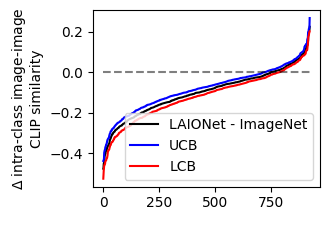

In [41]:
plt.figure(figsize=(3.4, 2.5))

diff_avg_intrasims = ic_ms_avg_intrasims - ic_avg_intrasims
diff_err_intrasims = np.sqrt(ic_ms_err_intrasims**2 + ic_err_intrasims**2)

sorted_locs = np.argsort(diff_avg_intrasims)

ucb_intrasims = np.sort(diff_avg_intrasims + diff_err_intrasims)
lcb_intrasims = np.sort(diff_avg_intrasims - diff_err_intrasims)

x = range(len(sorted_locs))

plt.plot(x, diff_avg_intrasims[sorted_locs], color='k')
plt.plot(x, ucb_intrasims, 'b')
plt.plot(x, lcb_intrasims, 'r')

plt.plot(x, [0]*len(x), 'k--', alpha=0.5)

plt.legend(['LAIONet - ImageNet', 'UCB', 'LCB'])

plt.xlabel(' ')
plt.ylabel(r'$\Delta$ intra-class image-image' + '\n' + 'CLIP similarity')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'intra-class_image-image_sim_diff_cond_text.pdf'), bbox_inches='tight')

print(f'avg < 0: {np.mean(diff_avg_intrasims < 0)}')
print(f'UCB < 0: {np.sum(ucb_intrasims < 0)} out of {len(ucb_intrasims)} ({np.mean(ucb_intrasims < 0)})')
print(f'LCB > 0: {np.sum(lcb_intrasims > 0)} out of {len(lcb_intrasims)} ({np.mean(lcb_intrasims > 0)})')

## Test per WNID per text-text th

In [42]:
tt_sim_ths = np.linspace(0.5, 0.75, 20)

In [43]:
prop_ic_has_lower_avgs = np.zeros((len(tt_sim_ths),))
prop_ic_ms_has_lower_avgs = np.zeros((len(tt_sim_ths),))
n_wnid_included = np.zeros((len(tt_sim_ths),))

for i_tt, tt_sim_th in enumerate(tqdm(tt_sim_ths)):
    # Load and filter
    ic_ms_avg_intrasims = []
    ic_ms_err_intrasims = []
    ic_avg_intrasims = []
    ic_err_intrasims = []

    for wnid in all_wnids:
        ic_ms_sim_path = os.path.join(cross_image_sim_path, ic_ms_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
        ic_sim_path = os.path.join(cross_image_sim_path, ic_prefix + cross_image_sim_prefix + f'({wnid}).pkl')

        if (not os.path.exists(ic_ms_sim_path)) or (not os.path.exists(ic_sim_path)):
            continue

        with open(ic_ms_sim_path, 'rb') as f:
            ic_ms_sim_dict = pickle.load(f)
        with open(ic_sim_path, 'rb') as f:
            ic_sim_dict = pickle.load(f)

        ic_ms_sim = ic_ms_sim_dict['similarities']
        ic_sim = ic_sim_dict['similarities']

        # Choose tha samples
        tt_sims = np.array(ic_ms_wnid2ictextsims[wnid])
        laion_indices = np.array(ic_ms_wnid2laionindices[wnid])
        laion_indices = laion_indices[tt_sims > tt_sim_th]

        # Filter sims
        locs_filtered = [
            ic_ms_sim_dict['index'].index(laion_index) for laion_index in laion_indices
            if laion_index in ic_ms_sim_dict['index']
        ]

        ic_ms_sim = ic_ms_sim[locs_filtered][:, locs_filtered]

        if len(ic_ms_sim) <= 1:
            continue

        # Extract and average sims.
        ic_ms_avg_intrasims.append(np.mean(vec(ic_ms_sim)))
        ic_ms_err_intrasims.append(1.96*np.std(vec(ic_ms_sim))/np.sqrt(len(vec(ic_ms_sim)) - 1))
        
        ic_avg_intrasims.append(np.mean(vec(ic_sim)))
        ic_err_intrasims.append(1.96*np.std(vec(ic_sim))/np.sqrt(len(vec(ic_sim)) - 1))
        
    # Count
    diff_avg_intrasims = np.array(ic_ms_avg_intrasims) - np.array(ic_avg_intrasims)
    diff_err_intrasims = np.sqrt(np.array(ic_ms_err_intrasims)**2 + np.array(ic_err_intrasims)**2)

    ucb_intrasims = diff_avg_intrasims + diff_err_intrasims
    lcb_intrasims = diff_avg_intrasims - diff_err_intrasims
    
    prop_ic_has_lower_avgs[i_tt] = np.mean(lcb_intrasims > 0)
    prop_ic_ms_has_lower_avgs[i_tt] = np.mean(ucb_intrasims < 0)
    n_wnid_included[i_tt] = len(lcb_intrasims)

  0%|                                                                                                               | 0/20 [00:00<?, ?it/s]/var/folders/0x/586kgp7s0gqbff4fcbg60twm0000gq/T/ipykernel_1438/2243046274.py:45: RuntimeWarning: invalid value encountered in scalar divide
  ic_ms_err_intrasims.append(1.96*np.std(vec(ic_ms_sim))/np.sqrt(len(vec(ic_ms_sim)) - 1))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.93s/it]


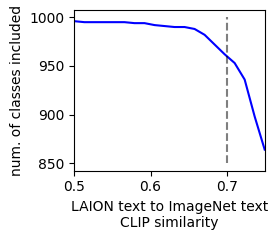

In [44]:
chosen_sim_th = 0.7

plt.figure(figsize=(3, 2.5))

plt.plot(tt_sim_ths, n_wnid_included, 'b')
plt.plot([chosen_sim_th]*2, [850, 1000], 'k--', alpha=0.5)
plt.xlim([tt_sim_ths[0], tt_sim_ths[-1]])
plt.xlabel('LAION text to ImageNet text\nCLIP similarity')
plt.ylabel('num. of classes included')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'n-class_after_filtering_ic_most_similar.pdf'), bbox_inches='tight')

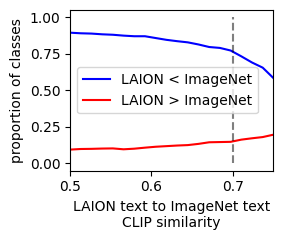

In [45]:
plt.figure(figsize=(3, 2.5))

plt.plot(tt_sim_ths, prop_ic_ms_has_lower_avgs, 'b')
plt.plot(tt_sim_ths, prop_ic_has_lower_avgs, 'r')
plt.plot([chosen_sim_th]*2, [0, 1], 'k--', alpha=0.5)
plt.xlim([tt_sim_ths[0], tt_sim_ths[-1]])
plt.xlabel('LAION text to ImageNet text\nCLIP similarity')
plt.ylabel('proportion of classes')

plt.legend(['LAION < ImageNet', 'LAION > ImageNet'])

plt.tight_layout()

plt.savefig(os.path.join('figs', 'prop_lower_sim_ic_most_similar.pdf'), bbox_inches='tight')

# Compare intra-class cross image similarities for ImageNetV2

## Settings

In [46]:
sm_prefix = configs.LAIONConfig.SUBSET_SM_FILTERED_PREFIX
iv2b_prefix = 'imagenetv2-matched-frequency_'
iv2a_prefix = 'imagenetv2-threshold0.7_'
iv2c_prefix = 'imagenetv2-top-images_'

## Load similarities

In [47]:
wnid2smsims = {}
wnid2iv2asims = {}
wnid2iv2bsims = {}
wnid2iv2csims = {}

for wnid in tqdm(all_wnids):
    sm_sim_path = os.path.join(cross_image_sim_path, sm_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    iv2a_sim_path = os.path.join(cross_image_sim_path, iv2a_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    iv2b_sim_path = os.path.join(cross_image_sim_path, iv2b_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    iv2c_sim_path = os.path.join(cross_image_sim_path, iv2c_prefix + cross_image_sim_prefix + f'({wnid}).pkl')
    
    if (not os.path.exists(sm_sim_path)) or (not os.path.exists(iv2a_sim_path)) or (not os.path.exists(iv2b_sim_path)) or (not os.path.exists(iv2c_sim_path)):
        continue

    with open(sm_sim_path, 'rb') as f:
        sm_sim_dict = pickle.load(f)
    with open(iv2a_sim_path, 'rb') as f:
        iv2a_sim_dict = pickle.load(f) 
    with open(iv2b_sim_path, 'rb') as f:
        iv2b_sim_dict = pickle.load(f) 
    with open(iv2c_sim_path, 'rb') as f:
        iv2c_sim_dict = pickle.load(f)
        
    if not isinstance(sm_sim_dict, dict):
        continue
        
    sm_sim = sm_sim_dict['similarities']
    iv2a_sim = iv2a_sim_dict['similarities']
    iv2b_sim = iv2b_sim_dict['similarities']
    iv2c_sim = iv2c_sim_dict['similarities']
        
    # Extract sims.
    wnid2smsims[wnid] = vec(sm_sim)
    wnid2iv2asims[wnid] = vec(iv2a_sim)
    wnid2iv2bsims[wnid] = vec(iv2b_sim)
    wnid2iv2csims[wnid] = vec(iv2c_sim)
    
print(len(wnid2smsims))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 453.79it/s]

899


## Resample

In [48]:
rs_sm_sims = []
rs_iv2a_sims = []
rs_iv2b_sims = []
rs_iv2c_sims = []

np.random.seed(111)
for wnid, sm_sims in wnid2smsims.items():
    iv2a_sims = wnid2iv2asims[wnid]
    iv2b_sims = wnid2iv2bsims[wnid]
    iv2c_sims = wnid2iv2csims[wnid]
    
    n_s_i = np.min([len(iv2a_sims), len(iv2b_sims), len(iv2c_sims), 100])
        
    rs_sm_sims.extend(np.random.choice(sm_sims, size=(n_s_i,), replace=True))
    rs_iv2a_sims.extend(np.random.choice(iv2a_sims, size=(n_s_i,), replace=True))
    rs_iv2b_sims.extend(np.random.choice(iv2b_sims, size=(n_s_i,), replace=True))
    rs_iv2c_sims.extend(np.random.choice(iv2c_sims, size=(n_s_i,), replace=True))

## Plot

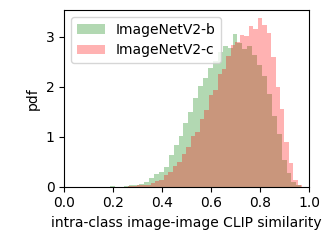

In [49]:
plt.figure(figsize=(3.4, 2.5))

# _ = plt.hist(rs_sm_sims, bins=40, color='b', alpha=0.3, density=True)
# _ = plt.hist(rs_iv2a_sims, bins=40, color='b', alpha=0.3, density=True)
_ = plt.hist(rs_iv2b_sims, bins=40, color='g', alpha=0.3, density=True)
_ = plt.hist(rs_iv2c_sims, bins=40, color='r', alpha=0.3, density=True)

plt.legend(['ImageNetV2-b', 'ImageNetV2-c'])

plt.xlabel('intra-class image-image CLIP similarity')
plt.ylabel('\npdf')

plt.xlim([0, 1])

plt.tight_layout()

plt.savefig(os.path.join('figs', f'{sm_prefix}{iv2b_prefix}{iv2c_prefix}{cross_image_sim_prefix}_resampled.pdf'), bbox_inches='tight')

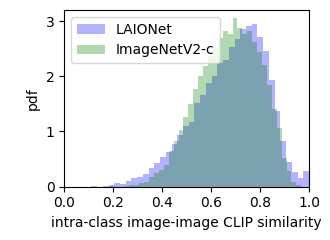

In [158]:
plt.figure(figsize=(3.4, 2.5))

_ = plt.hist(rs_sm_sims, bins=40, color='b', alpha=0.3, density=True)
_ = plt.hist(rs_iv2b_sims, bins=40, color='g', alpha=0.3, density=True)

plt.legend(['LAIONet', 'ImageNetV2-c'])

plt.xlabel('intra-class image-image CLIP similarity')
plt.ylabel('\npdf')

plt.xlim([0, 1])

plt.tight_layout()

plt.savefig(os.path.join('figs', f'{sm_prefix}{iv2c_prefix}{cross_image_sim_prefix}_resampled.pdf'))

## Test per WNID

In [50]:
sm_avg_intrasims = []
sm_err_intrasims = []
ic_avg_intrasims = []
ic_err_intrasims = []
iv2a_avg_intrasims = []
iv2a_err_intrasims = []
iv2b_avg_intrasims = []
iv2b_err_intrasims = []
iv2c_avg_intrasims = []
iv2c_err_intrasims = []

for wnid, sm_intrasims in tqdm(wnid2smsims.items()):
    if wnid not in wnid2icsims:
        continue
        
    ic_intrasims = wnid2icsims[wnid]
    iv2a_intrasims = wnid2iv2asims[wnid]
    iv2b_intrasims = wnid2iv2bsims[wnid]
    iv2c_intrasims = wnid2iv2csims[wnid]
    
    if len(sm_intrasims) < 7 or len(iv2a_intrasims) < 7 or len(iv2b_intrasims) < 7 or len(iv2c_intrasims) < 7:
        continue
        
    sm_avg_intrasims.append(np.mean(sm_intrasims))
    sm_err_intrasims.append(1.96*np.std(sm_intrasims)/np.sqrt(len(sm_intrasims) - 1))
    
    ic_avg_intrasims.append(np.mean(ic_intrasims))
    ic_err_intrasims.append(1.96*np.std(ic_intrasims)/np.sqrt(len(ic_intrasims) - 1))
    
    iv2a_avg_intrasims.append(np.mean(iv2a_intrasims))
    iv2a_err_intrasims.append(1.96*np.std(iv2a_intrasims)/np.sqrt(len(iv2a_intrasims) - 1))
    
    iv2b_avg_intrasims.append(np.mean(iv2b_intrasims))
    iv2b_err_intrasims.append(1.96*np.std(iv2b_intrasims)/np.sqrt(len(iv2b_intrasims) - 1))
    
    iv2c_avg_intrasims.append(np.mean(iv2c_intrasims))
    iv2c_err_intrasims.append(1.96*np.std(iv2c_intrasims)/np.sqrt(len(iv2c_intrasims) - 1))
    
sm_avg_intrasims = np.array(sm_avg_intrasims)
sm_err_intrasims = np.array(sm_err_intrasims)
ic_avg_intrasims = np.array(ic_avg_intrasims)
ic_err_intrasims = np.array(ic_err_intrasims)
iv2a_avg_intrasims = np.array(iv2a_avg_intrasims)
iv2a_err_intrasims = np.array(iv2a_err_intrasims)
iv2b_avg_intrasims = np.array(iv2b_avg_intrasims)
iv2b_err_intrasims = np.array(iv2b_err_intrasims)
iv2c_avg_intrasims = np.array(iv2c_avg_intrasims)
iv2c_err_intrasims = np.array(iv2c_err_intrasims)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 899/899 [00:00<00:00, 2396.52it/s]


avg < 0: 0.4765258215962441
UCB < 0: 273 out of 852 (0.3204225352112676)
LCB > 0: 326 out of 852 (0.3826291079812207)


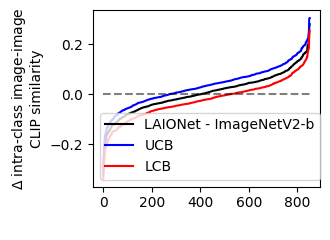

In [179]:
plt.figure(figsize=(3.4, 2.5))

# Change the next two lines + legened + file name for different ver of ImageNetV2
diff_avg_intrasims = sm_avg_intrasims - iv2b_avg_intrasims
diff_err_intrasims = np.sqrt(sm_err_intrasims**2 + iv2b_err_intrasims**2)

sorted_locs = np.argsort(diff_avg_intrasims)

ucb_intrasims = np.sort(diff_avg_intrasims + diff_err_intrasims)
lcb_intrasims = np.sort(diff_avg_intrasims - diff_err_intrasims)

x = range(len(sorted_locs))

plt.plot(x, diff_avg_intrasims[sorted_locs], color='k')
plt.plot(x, ucb_intrasims, 'b')
plt.plot(x, lcb_intrasims, 'r')

plt.plot(x, [0]*len(x), 'k--', alpha=0.5)

# Change here
plt.legend(['LAIONet - ImageNetV2-b', 'UCB', 'LCB'])

plt.xlabel(' ')
plt.ylabel(r'$\Delta$ intra-class image-image' + '\n' + 'CLIP similarity')

plt.tight_layout()

# Change here
plt.savefig(os.path.join('figs', f'intra-class_image-image_sim_diff_{iv2b_prefix[:-1]}.pdf'), bbox_inches='tight')

print(f'avg < 0: {np.mean(diff_avg_intrasims < 0)}')
print(f'UCB < 0: {np.sum(ucb_intrasims < 0)} out of {len(ucb_intrasims)} ({np.mean(ucb_intrasims < 0)})')
print(f'LCB > 0: {np.sum(lcb_intrasims > 0)} out of {len(lcb_intrasims)} ({np.mean(lcb_intrasims > 0)})')

## Vs. MTurk selection frequency

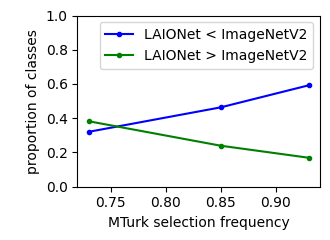

In [51]:
diff_avg_intrasims = sm_avg_intrasims - iv2a_avg_intrasims
diff_err_intrasims = np.sqrt(sm_err_intrasims**2 + iv2a_err_intrasims**2)
ucb_a_intrasims = np.sort(diff_avg_intrasims + diff_err_intrasims)
lcb_a_intrasims = np.sort(diff_avg_intrasims - diff_err_intrasims)

diff_avg_intrasims = sm_avg_intrasims - iv2b_avg_intrasims
diff_err_intrasims = np.sqrt(sm_err_intrasims**2 + iv2b_err_intrasims**2)
ucb_b_intrasims = np.sort(diff_avg_intrasims + diff_err_intrasims)
lcb_b_intrasims = np.sort(diff_avg_intrasims - diff_err_intrasims)

diff_avg_intrasims = sm_avg_intrasims - iv2c_avg_intrasims
diff_err_intrasims = np.sqrt(sm_err_intrasims**2 + iv2c_err_intrasims**2)
ucb_c_intrasims = np.sort(diff_avg_intrasims + diff_err_intrasims)
lcb_c_intrasims = np.sort(diff_avg_intrasims - diff_err_intrasims)

mturk_selec_freq = {'b': 0.73, 'a': 0.85, 'c': 0.93}

plt.figure(figsize=(3.4, 2.5))

plt.plot(
    [v for k, v in mturk_selec_freq.items()], 
    [
        np.mean(ucb_b_intrasims < 0),
        np.mean(ucb_a_intrasims < 0),
        np.mean(ucb_c_intrasims < 0),
    ],
    'b',
    marker='.'
)

plt.plot(
    [v for k, v in mturk_selec_freq.items()], 
    [
        np.mean(lcb_b_intrasims > 0),
        np.mean(lcb_a_intrasims > 0),
        np.mean(lcb_c_intrasims > 0),
    ],
    'g',
    marker='.'
)

plt.xlabel('MTurk selection frequency')
plt.ylabel('\nproportion of classes')

plt.legend(['LAIONet < ImageNetV2', 'LAIONet > ImageNetV2'])

plt.ylim([0, 1])

plt.tight_layout()

plt.savefig(os.path.join('figs', f'prop_lower_sim_imagenetv2.pdf'), bbox_inches='tight')


## Vs. ImageNet

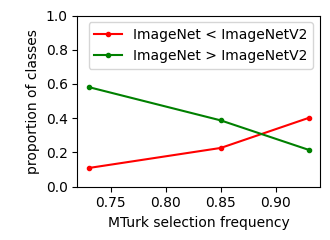

In [52]:
diff_avg_intrasims = ic_avg_intrasims - iv2a_avg_intrasims
diff_err_intrasims = np.sqrt(ic_err_intrasims**2 + iv2a_err_intrasims**2)
ucb_a_intrasims = np.sort(diff_avg_intrasims + diff_err_intrasims)
lcb_a_intrasims = np.sort(diff_avg_intrasims - diff_err_intrasims)

diff_avg_intrasims = ic_avg_intrasims - iv2b_avg_intrasims
diff_err_intrasims = np.sqrt(ic_err_intrasims**2 + iv2b_err_intrasims**2)
ucb_b_intrasims = np.sort(diff_avg_intrasims + diff_err_intrasims)
lcb_b_intrasims = np.sort(diff_avg_intrasims - diff_err_intrasims)

diff_avg_intrasims = ic_avg_intrasims - iv2c_avg_intrasims
diff_err_intrasims = np.sqrt(ic_err_intrasims**2 + iv2c_err_intrasims**2)
ucb_c_intrasims = np.sort(diff_avg_intrasims + diff_err_intrasims)
lcb_c_intrasims = np.sort(diff_avg_intrasims - diff_err_intrasims)

mturk_selec_freq = {'b': 0.73, 'a': 0.85, 'c': 0.93}

plt.figure(figsize=(3.4, 2.5))

plt.plot(
    [v for k, v in mturk_selec_freq.items()], 
    [
        np.mean(ucb_b_intrasims < 0),
        np.mean(ucb_a_intrasims < 0),
        np.mean(ucb_c_intrasims < 0),
    ],
    'r',
    marker='.'
)

plt.plot(
    [v for k, v in mturk_selec_freq.items()], 
    [
        np.mean(lcb_b_intrasims > 0),
        np.mean(lcb_a_intrasims > 0),
        np.mean(lcb_c_intrasims > 0),
    ],
    'g',
    marker='.'
)

plt.xlabel('MTurk selection frequency')
plt.ylabel('\nproportion of classes')

plt.legend(['ImageNet < ImageNetV2', 'ImageNet > ImageNetV2'])

plt.ylim([0, 1])

plt.tight_layout()

plt.savefig(os.path.join('figs', f'prop_lower_sim_imagenetv2_vs_imagenet.pdf'), bbox_inches='tight')
